<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Extra-Expriments" data-toc-modified-id="Extra-Expriments-1">Extra Expriments</a></span><ul class="toc-item"><li><span><a href="#EXP1.Correlation-Between-Noise-Amount-and-Accuracy" data-toc-modified-id="EXP1.Correlation-Between-Noise-Amount-and-Accuracy-1.1">EXP1.Correlation Between Noise Amount and Accuracy</a></span><ul class="toc-item"><li><span><a href="#Conclusion:" data-toc-modified-id="Conclusion:-1.1.1">Conclusion:</a></span></li></ul></li><li><span><a href="#EXP2.Find-the-Best-Kernel-Size" data-toc-modified-id="EXP2.Find-the-Best-Kernel-Size-1.2">EXP2.Find the Best Kernel Size</a></span><ul class="toc-item"><li><span><a href="#Conclusion:" data-toc-modified-id="Conclusion:-1.2.1">Conclusion:</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import ArtistAnimation
import cv2
from tqdm import tqdm

In [2]:
def add_pepper_and_salt(image,saltVSpepper = 0.5,amount = 0.02):
    row,col,ch = image.shape
    outImg = image.copy()
    # add salt
    num_salt = int(np.ceil(amount * image.size * saltVSpepper))
    row_coords = np.random.randint(0, row, num_salt)
    col_coords = np.random.randint(0, col, num_salt)
    outImg[row_coords,col_coords]=[255]*ch
    # add pepper
    num_pepper = int(np.ceil(amount* image.size * (1. - saltVSpepper)))
    row_coords = np.random.randint(0, row, num_pepper)
    col_coords = np.random.randint(0, col, num_pepper)
    outImg[row_coords,col_coords]=[0]*ch
    return outImg

find_the_difference= lambda mainImg,denoisedImg:np.mean(np.abs(np.subtract(mainImg,
                                                                           denoisedImg)))

# diff=lambda mainImg,denoisedImg=np.count_nonzero(np.subtract)
def noising_denoising(fileName,w=500,saltVSpepper = 0.5,noiseAmount = 0.05,kernelSize=5):
    assert kernelSize%2==1,ValueError("kernel size must be odd number")
    img=cv2.imread(fileName)
    img = cv2.resize(img,(w,img.shape[0]*w//img.shape[1]))
    noisyImg=add_pepper_and_salt(img,saltVSpepper = saltVSpepper,amount = noiseAmount)
    denoisedImg=cv2.medianBlur(noisyImg,kernelSize)
    return img,noisyImg,denoisedImg,find_the_difference(img,denoisedImg)

def imshow(title,img):
    plt.imshow(img)
    plt.title(title)
    plt.show()

82.0463943943944


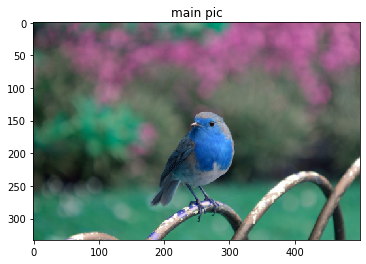

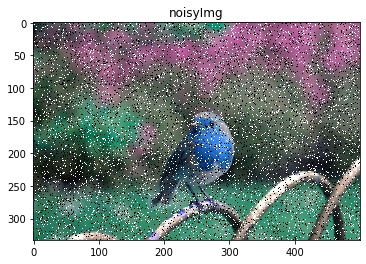

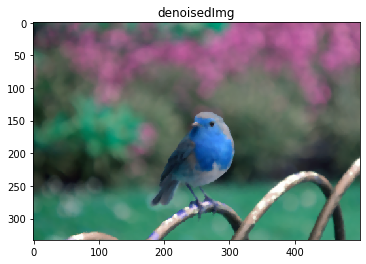

In [3]:
img,noisyImg,denoisedImg,diffValue=noising_denoising("./sample.jpg")
print(diffValue)
imshow("main pic",img)
imshow("noisyImg",noisyImg)
imshow("denoisedImg",denoisedImg)

**the asignment is done in this point** but lets do more experiments...
We have two adjustable prarmeters(`noiseAmount`,`kernalSize`).
Its clearly obvious `noiseAmount` and *difference between main image and denoised image* has same correlation.
But the question is how they exactly effect each other.

# Extra Expriments
## EXP1.Correlation Between Noise Amount and Accuracy
> **IDEA:** How `noiseAmount` exactly affects the *difference between main image and denoised image*

100%|██████████| 1000/1000 [00:24<00:00, 40.92it/s]


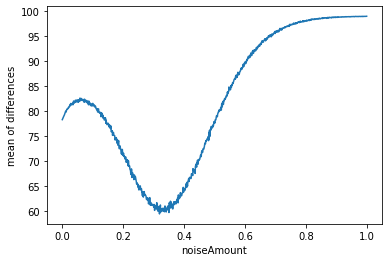

In [4]:
noiseAmounts=np.arange(0,1,0.001)
diffvalues=[noising_denoising("./sample.jpg",noiseAmount=i)[-1] for i in tqdm(noiseAmounts)]
plt.plot(noiseAmounts,diffvalues)
plt.xlabel("noiseAmount")
plt.ylabel("mean of differences")
plt.show()

### Conclusion:
To describe this graph lets devide it in two parts:
- $0 < noise amount < 0.3:$\
in this part we have very small noise so performing medin filter will destroy the image
- $0.3 < noise amount:$\
while noise amount increaces, more data will lost which means the lost data cant regnerated

> **IDEA:** lets change `kernelSize` to 3

## EXP2.Find the Best Kernel Size

100%|██████████| 1000/1000 [00:21<00:00, 45.76it/s]


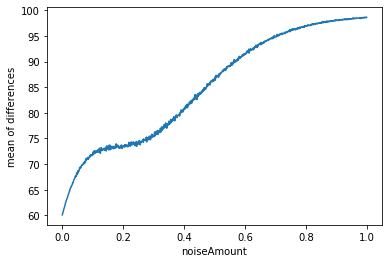

In [5]:
noiseAmounts=np.arange(0,1,0.001)
diffvalues=[noising_denoising("./sample.jpg",
                              noiseAmount=i,
                              kernelSize=3)[-1] for i in tqdm(noiseAmounts)]
plt.plot(noiseAmounts,diffvalues)
plt.xlabel("noiseAmount")
plt.ylabel("mean of differences")
plt.show()

It can be conclude we should use low kernel size when there is small amount of noise
> **IDEA:** lets implement a function to choose the best kernel size

diffValue is 68.52104904904905
optimizedKernel is 3


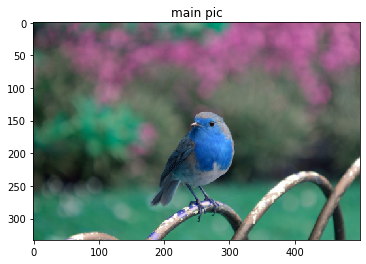

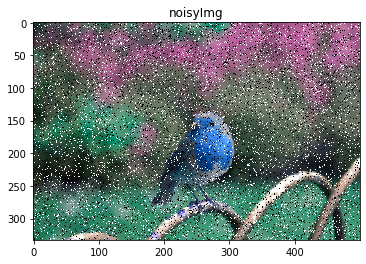

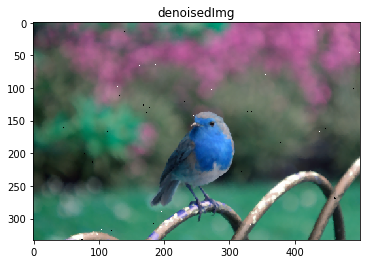

In [6]:
def noise_denoise_optimizedKernel(fileName,w=500,saltVSpepper = 0.5,noiseAmount = 0.05):
    img=cv2.imread(fileName)
    img = cv2.resize(img,(w,img.shape[0]*w//img.shape[1]))
    noisyImg=add_pepper_and_salt(img,saltVSpepper = saltVSpepper,amount = noiseAmount)
    denoisedImg,optimizedKernel=min([(cv2.medianBlur(noisyImg,i),i) for i in [3,5,7]],
                                    key=lambda x:find_the_difference(img,x[0]))
    return img,noisyImg,denoisedImg,find_the_difference(img,denoisedImg),optimizedKernel

img,noisyImg,denoisedImg,diffValue,optimizedKernel=noise_denoise_optimizedKernel("./sample.jpg")
print("diffValue is",diffValue)
print("optimizedKernel is",optimizedKernel)
imshow("main pic",img)
imshow("noisyImg",noisyImg)
imshow("denoisedImg",denoisedImg)

100%|██████████| 1000/1000 [00:44<00:00, 22.44it/s]


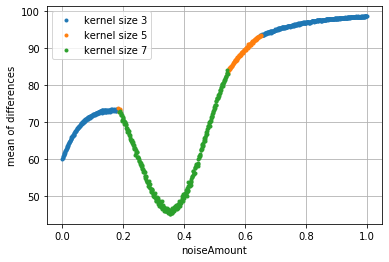

In [13]:
noiseAmounts=np.arange(0,1,0.001)
diffvalues=[[i]+list(noise_denoise_optimizedKernel("./sample.jpg",noiseAmount=i)[-2:]) for i in tqdm(noiseAmounts)]
for j in [3,5,7]:
    plt.plot([i[0] for i in diffvalues if i[2]==j],
             [i[1] for i in diffvalues if i[2]==j],
             '.',
             label=f'kernel size {j}')
plt.xlabel("noiseAmount")
plt.ylabel("mean of differences")
plt.legend()
plt.grid()
plt.show()

### Conclusion:
It can be conclude the kernel size should be choose wisley according to noise amount

> **TODO:** find a way to guess the noise amount